In [33]:
import numpy as np
import string
import os
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
import pandas as pd

In [34]:
reviews = "reviews.csv"
data_set = pd.read_csv(reviews)
data_set2 = pd.DataFrame(data_set, columns=['buisness_name','text']) 
data_set.head()




,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [35]:
Text = data_set['text']
buisness_name = data_set['business_name']

preprossed_text = []
stop_words = set(stopwords.words('english'))
st = ISRIStemmer()

for text in Text:
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.split()
    text = [st.stem(word) for word in text if not word in stop_words]
    text = ' '.join(text)
    preprossed_text.append(text)


data = pd.DataFrame({'business_name':buisness_name,'text':preprossed_text})
data.head()


,business_name,text
0,Haci'nin Yeri - Yigit Lokantasi,We went Marmaris wife holiday We chose restaur...
1,Haci'nin Yeri - Yigit Lokantasi,During holiday Marmaris ate fit food Its reall...
2,Haci'nin Yeri - Yigit Lokantasi,Prices affordable The menu photo cost 108 lira...
3,Haci'nin Yeri - Yigit Lokantasi,Turkeys cheapest artisan restaurant food delic...
4,Haci'nin Yeri - Yigit Lokantasi,I dont know look terms price performance point...


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
vectorizer = TfidfVectorizer()
vectorized_data = vectorizer.fit_transform(preprossed_text)


query = "service not good"
processed_query = query.translate(str.maketrans('', '', string.punctuation))
processed_query = processed_query.split()
processed_query = [st.stem(word) for word in processed_query if not word in stop_words]
processed_query = ' '.join(processed_query)

query_vector = vectorizer.transform([processed_query])


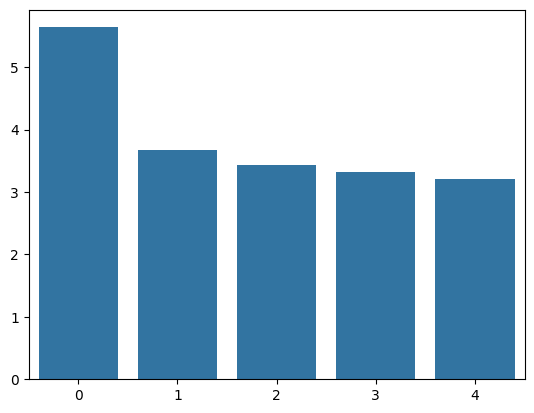

In [38]:
import seaborn as sns
lsa = TruncatedSVD(n_components=5)
lsa.fit(vectorized_data)
lsa_data = lsa.transform(vectorized_data)

lsa_query = lsa.transform(query_vector)
sigma=lsa.singular_values_
sns.barplot(x=list(range(len(sigma))), y=sigma)

similarity = cosine_similarity(lsa_data,lsa_query)


In [39]:
rankings = np.argsort(similarity,axis=0)[::-1]
rankings = rankings.flatten()

output = []
scores = []
buisness_name_sorted = []
ratings_sorted = []
Query = []
origina_review_category = []

for rank in rankings:
    output.append(data_set['text'][rank])
    scores.append(similarity[rank][0])
    buisness_name_sorted.append(data_set['business_name'][rank])
    ratings_sorted.append(data_set['rating'][rank])
    Query.append(query)
    origina_review_category.append(data_set['rating_category'][rank])



print("Top 5 reviews for the query are:")
for i in range(5):
    print(output[i])
    print("Similarity Score: ", scores[i])
    print("\n")

Top 5 reviews for the query are:
Service was fast. I ate ravioli; it was good.
Similarity Score:  0.9931145191214185


Pretty good sushi; attentive; friendly service..
Similarity Score:  0.9906180586751139


Generally good service thank you!
Similarity Score:  0.9902200248394547


foods are good. but the environment and service is not a full korean experience.
Similarity Score:  0.9722890695057577


The treats were excellent; but I did not like the main dish; it was not fully cooked; other than that; the treats and service were very good.
Similarity Score:  0.9697598290346178




In [40]:
final_data = pd.DataFrame({'buisness_name':buisness_name_sorted,'text':output,'score':scores,'rating':ratings_sorted ,'Query':Query ,'original_review_category':origina_review_category})
final_data.head()

,buisness_name,text,score,rating,Query,original_review_category
0,Alavara,Service was fast. I ate ravioli; it was good.,0.993115,4,service not good,outdoor_atmosphere
1,Sushico,Pretty good sushi; attentive; friendly service..,0.990618,5,service not good,outdoor_atmosphere
2,Koco Restaurant,Generally good service thank you!,0.990220,4,service not good,outdoor_atmosphere
3,Korelee,foods are good. but the environment and servic...,0.972289,3,service not good,menu
4,Gulcimen Aspava,The treats were excellent; but I did not like ...,0.969760,3,service not good,taste


In [41]:
words_topic_matrix = pd.DataFrame(lsa.components_,index=['topic1','topic2','topic3','topic4','topic5'],columns=vectorizer.get_feature_names_out())

#classifying most relevent words for each topic
top_words = []
for i in range(5):

    top_words.append(words_topic_matrix.loc['topic'+str(i+1)].sort_values(ascending=False)[0:10])

# Function to concatenate words of each topic
def concatenate_words(topics):
    concatenated_strings = []
    for topic in topics:
        concatenated_strings.append(' '.join(topic.index))
    return concatenated_strings

# Generate the concatenated strings
concatenated_strings = concatenate_words(top_words)

# Print the results
for i, string in enumerate(concatenated_strings):
    print(f"Topic {i+1}: {string}")




Topic 1: the good delicious place nice food service prices taste it
Topic 2: great ambiance recommend service thank thanks everything dishes delicious appetizers
Topic 3: delicious food reasonable recommend friendly fast prices staff fresh quite
Topic 4: expensive place nice ambiance it beautiful clean delicious crowded view
Topic 5: prices recommend expensive high reasonable little bit flavors like nice


In [42]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Encode the input text
input_text = "conclude the topic out of this text",concatenated_strings[0]
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text
output = model.generate(input_ids, max_length=10, temperature=0.7, num_return_sequences=1)

# Decode the output
output_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(output_text)

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The U.S. Department of Justice
